# Convolutional Neral Network
Show how to build convolutional neral network with tensorflow higher-level API

## Biref theory
![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)


## Operations in CNN
Frequently used operations in CNN can be summarized below:
- Convolution: extract feature with convolution computation between kernel weights and image inputs
- Pooling:  very similar to how convolution operation works,  but using different computations, such as max operation.


# Dataset
This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)


# Emplementation
## Import modules

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
minist = input_data.read_data_sets("/tmp/data", one_hot=False)
                                  
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Parameters


In [9]:
learning_rate = 0.001
num_steps = 2000
batch_size = 128

num_input = 784
n_classes = 10
dropout = 0.25

## Building nets
- network structure
- loss
- optimizer

In [10]:
# Create network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    """
    x_dict: input in dicationary format 
    """
    with tf.variable_scope('ConvNet', reuse=reuse):
        x = x_dict['images']
        x = tf.reshape(x, shape=[-1, 28, 28, 1]) # reshpae into 2d image
        
        # Convolution layer with 32 filters and kenel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
        
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        
        fc1 = tf.contrib.layers.flatten(conv2)
        fc1 = tf.layers.dense(fc1, 1024)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
        
        # Output with 10 nerons, each stands for the probability of a number
        out = tf.layers.dense(fc1, n_classes)
        
    return out
        

In [11]:
# build the whole train/eval/predict elements together
def model_fn(features, labels, mode):
    logits_train = conv_net(features, n_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, n_classes, dropout, reuse=True, is_training=False)
    
    pred_classes = tf.argmax(logits_test, axis =1) # axis=1 means max in row
    pred_probas = tf.nn.softmax(logits_test)
    
    # predict
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)
     # train
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits_train, labels =tf.cast(labels, dtype=tf.int32)))
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # evaluate
    acc_op = tf.metrics.accuracy(labels= labels, predictions = pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs
    
 

In [12]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp2mjw030u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7580f31b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Define input function for training

In [13]:
input_fn = tf.estimator.inputs.numpy_input_fn(
x = {'images':minist.train.images}, y=minist.train.labels,
batch_size = batch_size, num_epochs=None, shuffle=True)

# train model
model.train(input_fn, steps = num_steps)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp2mjw030u/model.ckpt.
INFO:tensorflow:loss = 2.30503, step = 1
INFO:tensorflow:global_step/sec: 25.3113
INFO:tensorflow:loss = 0.110726, step = 101 (3.952 sec)
INFO:tensorflow:global_step/sec: 25.3417
INFO:tensorflow:loss = 0.0425577, step = 201 (3.946 sec)
INFO:tensorflow:global_step/sec: 25.3609
INFO:tensorflow:loss = 0.0686854, step = 301 (3.943 sec)
INFO:tensorflow:global_step/sec: 25.9443
INFO:tensorflow:loss = 0.0639506, step = 401 (3.854 sec)
INFO:te

## Define input function for evalutation

In [14]:
input_fn = tf.estimator.inputs.numpy_input_fn(
x= {'images':minist.test.images}, y = minist.test.labels,
   batch_size = batch_size, shuffle = False)
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-17-04:44:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2mjw030u/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-17-04:44:42
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9895, global_step = 2000, loss = 0.0378753
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp2mjw030u/model.ckpt-2000


{'accuracy': 0.98949999, 'global_step': 2000, 'loss': 0.037875313}

## Prediction single images

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp2mjw030u/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


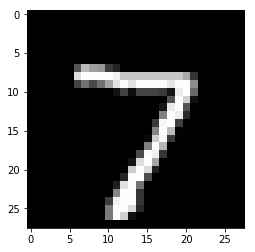

Prediction label: 7


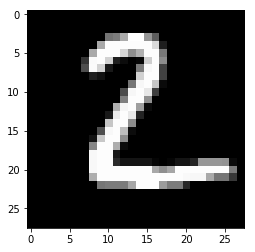

Prediction label: 2


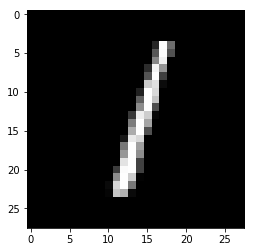

Prediction label: 1


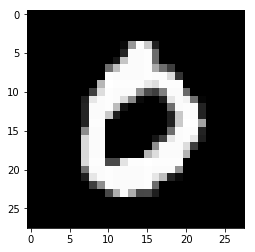

Prediction label: 0


In [15]:
n_images = 4
test_images = minist.test.images[:n_images]
input_fn = tf.estimator.inputs.numpy_input_fn(
x= {'images':test_images}, shuffle = False)
preds = list(model.predict(input_fn))

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap = 'gray')
    plt.show()
    print("Prediction label: {}".format(preds[i]))